In [68]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1918 entries, 2019-07-01 to 2024-09-29
Freq: D
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Local Route   1918 non-null   int64  
 1   Light Rail    1918 non-null   int64  
 2   Peak Service  1918 non-null   int64  
 3   Rapid Route   1918 non-null   int64  
 4   School        1918 non-null   int64  
 5   Other         1898 non-null   float64
dtypes: float64(1), int64(5)
memory usage: 169.4 KB
None


In [69]:
print(df.describe())

       Local Route  Light Rail  Peak Service  Rapid Route   School    Other
count     1,918.00    1,918.00      1,918.00     1,918.00 1,918.00 1,898.00
mean      9,891.40    7,195.45        179.58    12,597.21 2,352.69    43.39
std       6,120.72    3,345.62        156.53     6,720.49 2,494.77    41.75
min           1.00        0.00          0.00         0.00     0.00     0.00
25%       3,044.50    4,463.50          0.00     6,383.00     0.00    14.00
50%      11,417.00    7,507.00        193.00    13,106.50   567.50    40.00
75%      15,517.50   10,008.25        313.75    17,924.75 4,914.00    68.00
max      21,070.00   15,154.00      1,029.00    28,678.00 7,255.00 1,105.00


<Axes: >

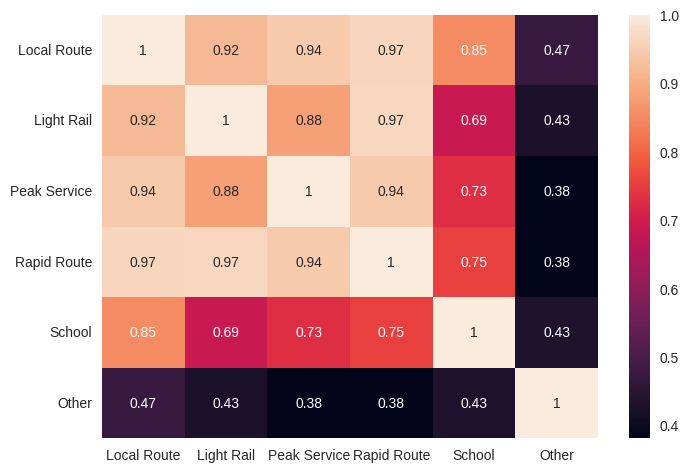

In [70]:
df.corr()
sns.heatmap(df.corr(), annot=True)

In [71]:

# IMPORTS & SETTINGS
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

# Statsmodels / Prophet / sklearn / xgboost
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Prophet: optional; try to import, if not available the code will continue without it
try:
    from prophet import Prophet
except Exception as e:
    Prophet = None
    print("Prophet not installed. You can 'pip install prophet' to enable it.")

import xgboost as xgb

# plotting defaults
plt.style.use("seaborn-v0_8")
pd.options.display.float_format = '{:,.2f}'.format

print("Environment ready. Libraries loaded.")


Environment ready. Libraries loaded.


In [72]:
#LOAD RAW DATA
DATA_PATH = "/content/Daily_Public_Transport_Passenger_Journeys_by_Service_Type_20250603.csv"  # update if needed

raw_df = pd.read_csv(DATA_PATH)
print("RAW data preview (first 10 rows):")
display(raw_df.head(10))
print("\nRAW data info:")
display(raw_df.info())
print("\nRAW descriptive stats (numeric):")
display(raw_df.describe().T)


RAW data preview (first 10 rows):


,Date,Local Route,Light Rail,Peak Service,Rapid Route,School,Other
0,30/08/2024,16436,10705,225,19026,3925,59.00
1,15/09/2023,15499,10671,267,18421,4519,61.00
2,28/12/2021,1756,2352,0,3775,0,13.00
3,11/01/2023,10536,8347,223,14072,0,48.00
4,11/09/2021,820,612,0,1283,0,11.00
5,31/01/2020,12977,9620,242,19327,0,0.00
6,01/03/2023,17387,11627,362,21753,5544,108.00
7,17/07/2021,2735,3651,0,5236,0,20.00
8,07/03/2023,17674,11859,364,21560,5700,91.00
9,12/11/2020,13405,6989,273,13688,4983,74.00



RAW data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1918 entries, 0 to 1917
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          1918 non-null   object 
 1   Local Route   1918 non-null   int64  
 2   Light Rail    1918 non-null   int64  
 3   Peak Service  1918 non-null   int64  
 4   Rapid Route   1918 non-null   int64  
 5   School        1918 non-null   int64  
 6   Other         1898 non-null   float64
dtypes: float64(1), int64(5), object(1)
memory usage: 105.0+ KB


None


RAW descriptive stats (numeric):


,count,mean,std,min,25%,50%,75%,max
Local Route,"1,918.00","9,891.40","6,120.72",1.00,"3,044.50","11,417.00","15,517.50","21,070.00"
Light Rail,"1,918.00","7,195.45","3,345.62",0.00,"4,463.50","7,507.00","10,008.25","15,154.00"
Peak Service,"1,918.00",179.58,156.53,0.00,0.00,193.00,313.75,"1,029.00"
Rapid Route,"1,918.00","12,597.21","6,720.49",0.00,"6,383.00","13,106.50","17,924.75","28,678.00"
School,"1,918.00","2,352.69","2,494.77",0.00,0.00,567.50,"4,914.00","7,255.00"
Other,"1,898.00",43.39,41.75,0.00,14.00,40.00,68.00,"1,105.00"


In [73]:
# PREPROCESSING (date parse -> sort -> index -> asfreq)
df = raw_df.copy()

# detect date column (first column if named 'Date' or contains 'date')
possible_date_cols = [c for c in df.columns if 'date' in c.lower()]
date_col = possible_date_cols[0] if possible_date_cols else df.columns[0]
print("Using date column:", date_col)

# Convert to datetime (dayfirst=True because dataset used day-first)
df[date_col] = pd.to_datetime(df[date_col], dayfirst=True, errors='coerce')

# Sort and set index
df = df.sort_values(date_col).reset_index(drop=True)
df = df.set_index(date_col)

# Force daily frequency and show if any gaps exist
df = df.asfreq('D')
missing_dates = pd.date_range(df.index.min(), df.index.max()).difference(df.index)
print("Missing dates count:", len(missing_dates))

# Show first 10 rows after basic preprocessing
print("\nData after basic preprocessing (first 10 rows):")
display(df.head(10))

# Show missing counts per column (before filling)
print("\nMissing value counts (before fill):")
display(df.isna().sum())


Using date column: Date
Missing dates count: 0

Data after basic preprocessing (first 10 rows):


,Local Route,Light Rail,Peak Service,Rapid Route,School,Other
Date,,,,,,
2019-07-01,15987,9962,407,21223,3715,NaN
2019-07-02,16895,10656,409,21715,3993,NaN
2019-07-03,16613,10658,427,22025,3638,NaN
2019-07-04,16604,10445,437,21868,3576,NaN
2019-07-05,16040,10532,400,20697,2856,NaN
2019-07-06,5214,6141,0,6925,0,NaN
2019-07-07,4065,4332,0,5426,0,NaN
2019-07-08,13078,9442,422,18848,0,0.00
2019-07-09,13835,10550,455,19862,0,1.00



Missing value counts (before fill):


,0
Local Route,0
Light Rail,0
Peak Service,0
Rapid Route,0
School,0
Other,20


In [74]:
# FILL MISSING VALUES (INTERPOLATE / FILL)

clean_df = df.copy()

# Numeric columns interpolation by time (linear)
numeric_cols = clean_df.select_dtypes(include=[np.number]).columns.tolist()
clean_df[numeric_cols] = clean_df[numeric_cols].interpolate(method='time')

# For any remaining NaNs (like start/end), forward-fill then back-fill
clean_df[numeric_cols] = clean_df[numeric_cols].ffill().bfill()

print("Missing value counts after filling:")
display(clean_df.isna().sum())

# Show simple before/after summary for a representative column
rep_col = 'Rapid Route' if 'Rapid Route' in clean_df.columns else numeric_cols[0]
print("\nExample: before vs after interpolation (first 10 rows):")
compare = pd.DataFrame({
    "raw_before": df[rep_col].head(10).values,
    "clean_after": clean_df[rep_col].head(10).values
})
display(compare)


Missing value counts after filling:


,0
Local Route,0
Light Rail,0
Peak Service,0
Rapid Route,0
School,0
Other,0



Example: before vs after interpolation (first 10 rows):


,raw_before,clean_after
0,21223,21223
1,21715,21715
2,22025,22025
3,21868,21868
4,20697,20697
5,6925,6925
6,5426,5426
7,18848,18848
8,19862,19862
9,19502,19502


In [75]:
#Add time-based features directly inside clean_df so all models can use them
clean_df['dayofweek'] = clean_df.index.dayofweek
clean_df['is_weekend'] = (clean_df['dayofweek'] >= 5).astype(int)


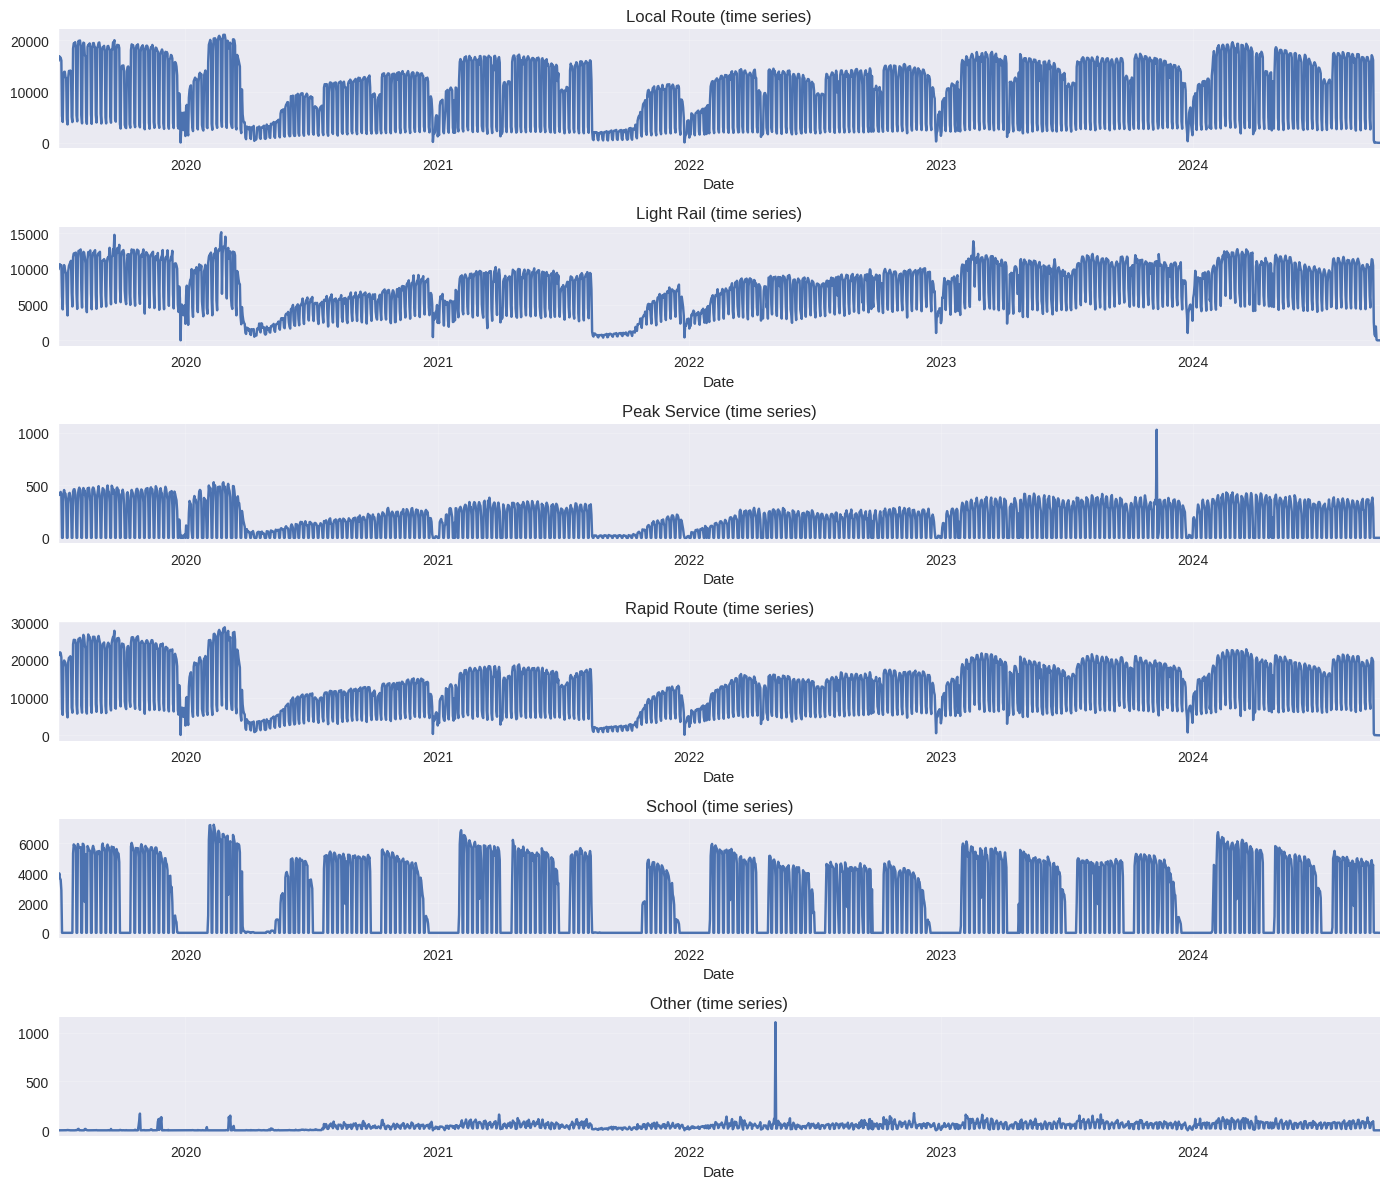

In [76]:
# QUICK EDA PLOT - OVERVIEW OF EACH SERVICE

services = ['Local Route','Light Rail','Peak Service','Rapid Route','School','Other']
services = [s for s in services if s in clean_df.columns]

plt.figure(figsize=(14, 12))
for i, col in enumerate(services):
    ax = plt.subplot(len(services), 1, i+1)
    clean_df[col].plot(ax=ax, legend=False)
    ax.set_title(f"{col} (time series)")
    ax.grid(alpha=0.2)
plt.tight_layout()
plt.show()


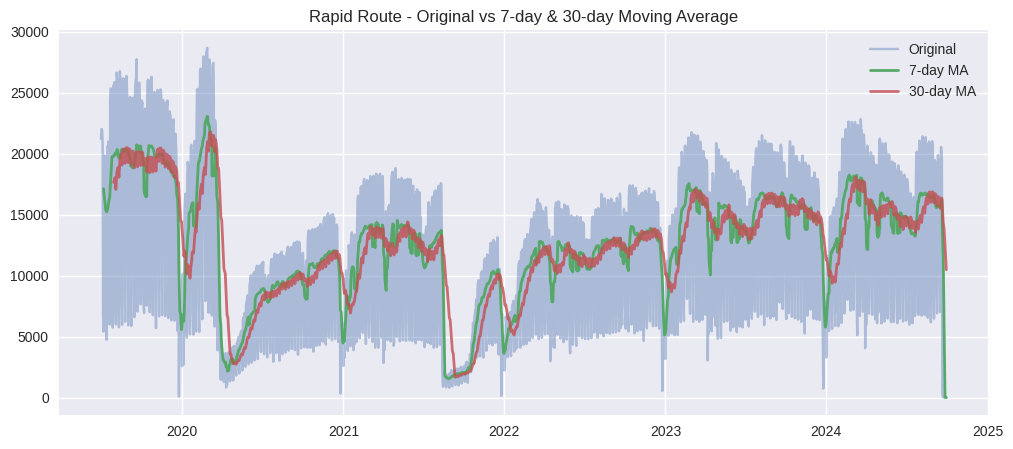

In [77]:
# MOVING AVERAGE (SMOOTHING) - SHOW EFFECT

rep = 'Rapid Route' if 'Rapid Route' in services else services[0]
clean_df[f'{rep}_MA7'] = clean_df[rep].rolling(window=7).mean()
clean_df[f'{rep}_MA30'] = clean_df[rep].rolling(window=30).mean()

plt.figure(figsize=(12,5))
plt.plot(clean_df[rep], alpha=0.4, label='Original')
plt.plot(clean_df[f'{rep}_MA7'], label='7-day MA', linewidth=2)
plt.plot(clean_df[f'{rep}_MA30'], label='30-day MA', linewidth=2, alpha=0.8)
plt.title(f"{rep} - Original vs 7-day & 30-day Moving Average")
plt.legend()
plt.show()


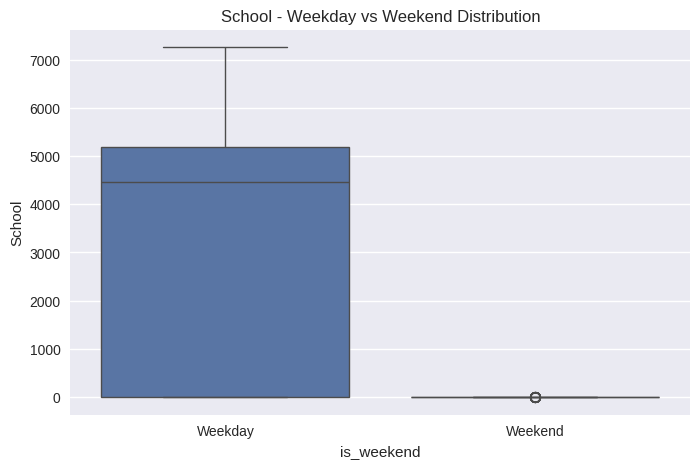

In [78]:
# WEEKDAY VS WEEKEND


data = clean_df.copy()
data['dayofweek'] = data.index.dayofweek
data['is_weekend'] = (data['dayofweek'] >= 5).astype(int)

rep = 'School' if 'School' in services else services[0]
plt.figure(figsize=(8,5))
sns.boxplot(x='is_weekend', y=rep, data=data.reset_index())
plt.xticks([0,1], ['Weekday', 'Weekend'])
plt.title(f"{rep} - Weekday vs Weekend Distribution")
plt.show()


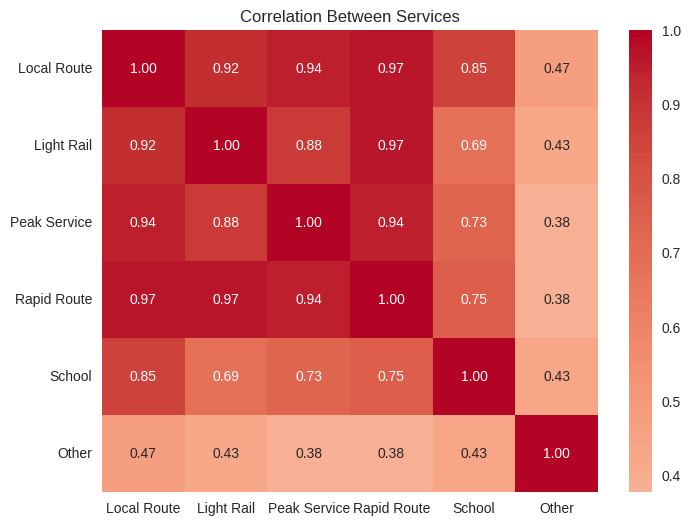

Correlation matrix (rounded):


,Local Route,Light Rail,Peak Service,Rapid Route,School,Other
Local Route,1.00,0.92,0.94,0.97,0.85,0.47
Light Rail,0.92,1.00,0.88,0.97,0.69,0.43
Peak Service,0.94,0.88,1.00,0.94,0.73,0.38
Rapid Route,0.97,0.97,0.94,1.00,0.75,0.38
School,0.85,0.69,0.73,0.75,1.00,0.43
Other,0.47,0.43,0.38,0.38,0.43,1.00


In [79]:
# CORRELATION HEATMAP BETWEEN SERVICES

corr_matrix = clean_df[services].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation Between Services")
plt.show()

print("Correlation matrix (rounded):")
display(corr_matrix.round(2))


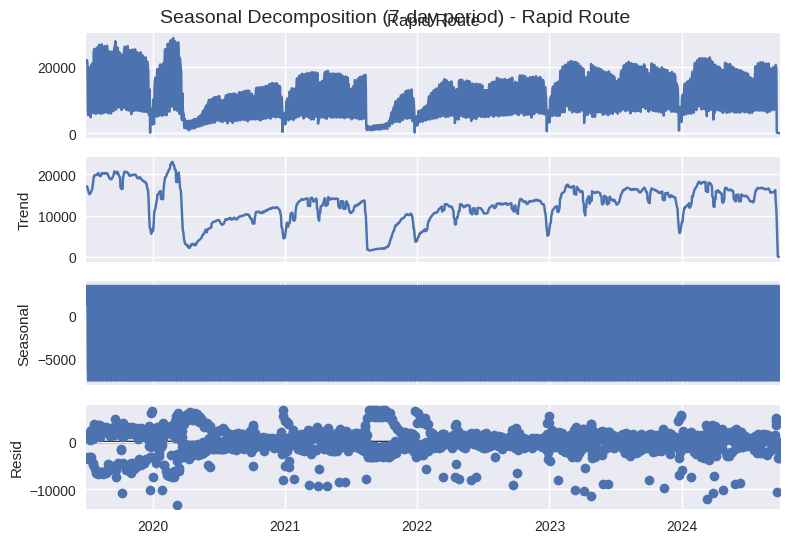

In [80]:
# SEASONAL DECOMPOSITION (weekly seasonality)

from statsmodels.tsa.seasonal import seasonal_decompose

rep = 'Rapid Route' if 'Rapid Route' in services else services[0]
decomp = seasonal_decompose(clean_df[rep].dropna(), model='additive', period=7)
decomp.plot()
plt.suptitle(f"Seasonal Decomposition (7-day period) - {rep}", fontsize=14)
plt.show()


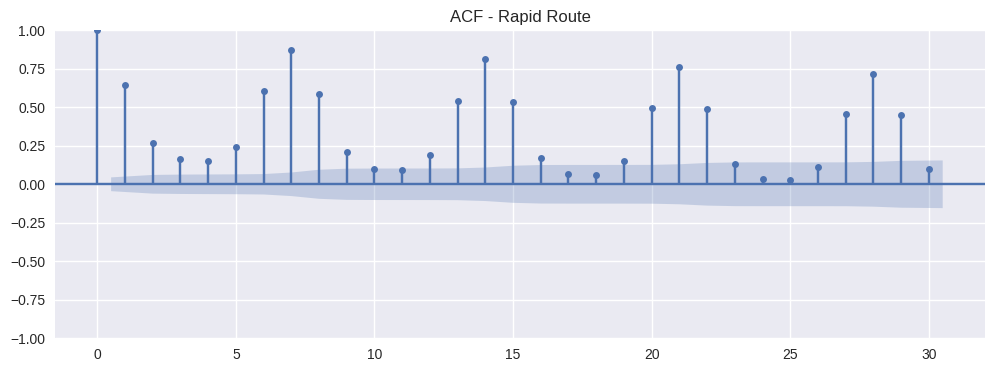

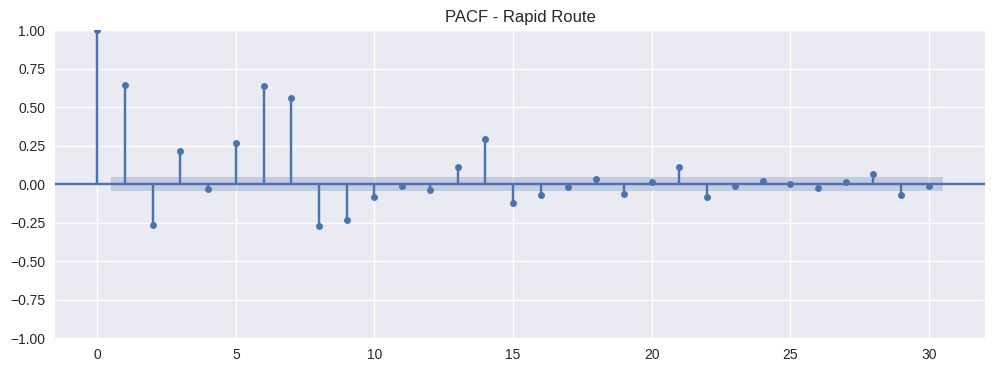

In [81]:
# ACF & PACF (to inspect autocorrelation)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

rep = 'Rapid Route' if 'Rapid Route' in services else services[0]
series_for_acf = clean_df[rep].dropna()

plt.figure(figsize=(12,4))
plot_acf(series_for_acf, lags=30, ax=plt.gca())
plt.title(f"ACF - {rep}")
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(series_for_acf, lags=30, ax=plt.gca(), method='ywm')
plt.title(f"PACF - {rep}")
plt.show()


In [82]:

# Feature Engineering for all services

# Make a fresh copy from clean_df
fe_df = clean_df.copy()

services = ["Local Route", "Light Rail", "Peak Service", "Rapid Route", "School", "Other"]

# Add lag and rolling features for every service
for col in services:
    fe_df[f"{col}_lag1"] = fe_df[col].shift(1)
    fe_df[f"{col}_lag7"] = fe_df[col].shift(7)
    fe_df[f"{col}_lag30"] = fe_df[col].shift(30)

    fe_df[f"{col}_roll7"] = fe_df[col].rolling(7).mean()
    fe_df[f"{col}_roll30"] = fe_df[col].rolling(30).mean()

print("Feature engineered DF created. Shape:", fe_df.shape)
fe_df.head()


Feature engineered DF created. Shape: (1918, 40)


,Local Route,Light Rail,Peak Service,Rapid Route,School,Other,dayofweek,is_weekend,Rapid Route_MA7,Rapid Route_MA30,...,School_lag1,School_lag7,School_lag30,School_roll7,School_roll30,Other_lag1,Other_lag7,Other_lag30,Other_roll7,Other_roll30
Date,,,,,,,,,,,,,,,,,,,,,
2019-07-01,15987,9962,407,21223,3715,0.00,0,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-02,16895,10656,409,21715,3993,0.00,1,0,NaN,NaN,...,"3,715.00",NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN
2019-07-03,16613,10658,427,22025,3638,0.00,2,0,NaN,NaN,...,"3,993.00",NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN
2019-07-04,16604,10445,437,21868,3576,0.00,3,0,NaN,NaN,...,"3,638.00",NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN
2019-07-05,16040,10532,400,20697,2856,0.00,4,0,NaN,NaN,...,"3,576.00",NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN


In [83]:
clean_df.head()


,Local Route,Light Rail,Peak Service,Rapid Route,School,Other,dayofweek,is_weekend,Rapid Route_MA7,Rapid Route_MA30
Date,,,,,,,,,,
2019-07-01,15987,9962,407,21223,3715,0.00,0,0,NaN,NaN
2019-07-02,16895,10656,409,21715,3993,0.00,1,0,NaN,NaN
2019-07-03,16613,10658,427,22025,3638,0.00,2,0,NaN,NaN
2019-07-04,16604,10445,437,21868,3576,0.00,3,0,NaN,NaN
2019-07-05,16040,10532,400,20697,2856,0.00,4,0,NaN,NaN


In [84]:
fe_df.head()


,Local Route,Light Rail,Peak Service,Rapid Route,School,Other,dayofweek,is_weekend,Rapid Route_MA7,Rapid Route_MA30,...,School_lag1,School_lag7,School_lag30,School_roll7,School_roll30,Other_lag1,Other_lag7,Other_lag30,Other_roll7,Other_roll30
Date,,,,,,,,,,,,,,,,,,,,,
2019-07-01,15987,9962,407,21223,3715,0.00,0,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-02,16895,10656,409,21715,3993,0.00,1,0,NaN,NaN,...,"3,715.00",NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN
2019-07-03,16613,10658,427,22025,3638,0.00,2,0,NaN,NaN,...,"3,993.00",NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN
2019-07-04,16604,10445,437,21868,3576,0.00,3,0,NaN,NaN,...,"3,638.00",NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN
2019-07-05,16040,10532,400,20697,2856,0.00,4,0,NaN,NaN,...,"3,576.00",NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN


In [85]:
# TRAIN / VALIDATION / TEST SPLIT (time-based)


FORECAST_HORIZON = 7
VALIDATION_DAYS = 14

def split_time_series(series, validation_days=VALIDATION_DAYS, horizon=FORECAST_HORIZON):
    """
    returns train_series, val_series, test_series
    train ends before validation window, validation is the chunk before final test
    """
    total = len(series)
    train_end = total - (validation_days + horizon)
    val_end = total - horizon
    train = series.iloc[:train_end]
    val = series.iloc[train_end:val_end]
    test = series.iloc[val_end:]
    return train, val, test

# Example demonstration for Rapid Route
example_series = clean_df[rep]
train_ex, val_ex, test_ex = split_time_series(example_series)
print("Train / Val / Test lengths (example):", len(train_ex), len(val_ex), len(test_ex))


Train / Val / Test lengths (example): 1897 14 7


In [87]:
# BASELINE FUNCTIONS - Naive & Moving Average


def create_naive_forecast(train_series, val_series):
    """Naive forecast: use the last observed value from train for the entire validation horizon"""
    return np.repeat(train_series.iloc[-1], len(val_series))

def create_moving_average_forecast(train_series, val_series, window=7):
    """Moving average forecast: last window mean from train repeated for validation horizon"""
    ma_value = train_series.rolling(window).mean().iloc[-1]
    return np.repeat(ma_value, len(val_series))

def compute_metrics(true_values, predicted_values):
    mae = mean_absolute_error(true_values, predicted_values)

    mse = mean_squared_error(true_values, predicted_values)
    rmse = np.sqrt(mse)

    mape = np.mean(np.abs((true_values - predicted_values) / (true_values + 1e-9))) * 100

    return {"mae": mae, "rmse": rmse, "mape": mape}


In [88]:
# SARIMAX TRAIN & PREDICT (with optional exogenous)


def train_and_predict_sarimax(train_series, val_series, test_series, exog_train=None, exog_val=None, exog_test=None,
                              order=(1,1,1), seasonal_order=(1,1,1,7)):
    """
    Fit SARIMAX on train_series (optionally with exogenous variables), then predict val and test periods.
    Returns val_predictions, test_predictions, fitted_model
    """
    model = SARIMAX(train_series, order=order, seasonal_order=seasonal_order, exog=exog_train)
    fitted = model.fit(disp=False)
    val_pred = fitted.predict(start=val_series.index[0], end=val_series.index[-1], exog=exog_val)
    test_pred = fitted.predict(start=test_series.index[0], end=test_series.index[-1], exog=exog_test)
    return val_pred, test_pred, fitted


In [89]:
# PROPHET TRAIN & PREDICT

def train_and_predict_prophet(series, train_series, val_series, test_series, add_regressors=None):
    """
    Train Prophet on training part of series and predict val and test.
    add_regressors: dict of {name: series} to add as regressors (must align by date)
    Returns val_pred_array, test_pred_array
    """
    if Prophet is None:
        # Prophet not installed — return naive fallback
        print("Prophet not available — skipping Prophet for this target.")
        return np.repeat(train_series.iloc[-1], len(val_series)), np.repeat(train_series.iloc[-1], len(test_series))

    # Build dataframe for Prophet
    df_prop = pd.DataFrame({"ds": series.index, "y": series.values})
    m = Prophet()
    # Add regressors if provided (e.g., is_weekend)
    if add_regressors:
        for name, reg_series in add_regressors.items():
            m.add_regressor(name)
            df_prop[name] = reg_series.values

    # Fit on training period only
    train_len = len(train_series)
    m.fit(df_prop.iloc[:train_len])

    future = m.make_future_dataframe(periods=len(val_series) + len(test_series))
    # attach regressors to future if present
    if add_regressors:
        for name, reg_series in add_regressors.items():
            future = future.merge(pd.DataFrame({"ds": reg_series.index, name: reg_series.values}), on='ds', how='left')
    forecast = m.predict(future)
    forecast_idx = forecast.set_index('ds')
    val_pred = forecast_idx.loc[val_series.index[0]:val_series.index[-1]]['yhat'].values
    test_pred = forecast_idx.loc[test_series.index[0]:test_series.index[-1]]['yhat'].values
    return val_pred, test_pred


In [90]:
# XGBOOST TRAIN & PREDICT (feature-based)


def train_and_predict_xgboost(feature_df, target_col, train_idx, val_idx, test_idx):
    """
    feature_df: dataframe with features (must include target and features like lags/rolling)
    train_idx, val_idx, test_idx: index slices for splitting
    Returns val_pred, test_pred, trained_model
    """
    # Features: all columns except targets (we keep only engineered cols)
    # build X and y
    X = feature_df.drop(columns=[c for c in services if c in feature_df.columns], errors='ignore')
    y = feature_df[target_col]

    X_train = X.loc[train_idx]
    y_train = y.loc[train_idx]
    X_val = X.loc[val_idx]
    y_val = y.loc[val_idx]
    X_test = X.loc[test_idx]

    model = xgb.XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, verbosity=0)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=20, verbose=False)

    val_pred = model.predict(X_val)
    test_pred = model.predict(X_test)
    return val_pred, test_pred, model


In [91]:
# FINAL FIXED PIPELINE FUNCTION

def run_full_pipeline_for_service(service, forecast_horizon=30, do_prophet=True):
    """
    Runs full pipeline for one service:
    - Naive
    - MA7
    - SARIMA
    - Prophet
    - Ensemble
    """

    svc_series = fe_df[service].dropna()

    # Train-test split
    train = svc_series.iloc[:-21]
    test = svc_series.iloc[-21:]

    # Naive Forecast
    naive_pred = pd.Series([train.iloc[-1]] * len(test), index=test.index)

    # Moving Average (MA7)
    ma7_value = train.rolling(7).mean().iloc[-1]
    ma7_pred = pd.Series([ma7_value] * len(test), index=test.index)

    # SARIMA (NO exogenous)
    try:
        sarima_model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,7))
        sarima_fit = sarima_model.fit(disp=False)
        sarima_pred = sarima_fit.forecast(steps=len(test))
    except Exception as e:
        print("SARIMA error:", e)
        sarima_pred = pd.Series([np.nan] * len(test), index=test.index)

    # Prophet Forecast
    if do_prophet:
        try:
            prof_df = pd.DataFrame({"ds": train.index, "y": train.values})
            prof_df["is_weekend"] = (prof_df["ds"].dt.dayofweek >= 5).astype(int)
            prof_df["dayofweek"] = prof_df["ds"].dt.dayofweek

            prophet_model = Prophet(weekly_seasonality=True, daily_seasonality=False)
            prophet_model.add_regressor("is_weekend")
            prophet_model.add_regressor("dayofweek")

            prophet_model.fit(prof_df)

            future = prophet_model.make_future_dataframe(periods=len(test))
            future["is_weekend"] = (future["ds"].dt.dayofweek >= 5).astype(int)
            future["dayofweek"] = future["ds"].dt.dayofweek

            prophet_pred_full = prophet_model.predict(future)
            prophet_pred = prophet_pred_full.set_index("ds")["yhat"].iloc[-len(test):]
        except Exception as e:
            print("Prophet error:", e)
            prophet_pred = pd.Series([np.nan] * len(test), index=test.index)
    else:
        prophet_pred = pd.Series([np.nan] * len(test), index=test.index)

    # XGBoost disabled
    print("XGBoost skipped for stability.")
    xgb_pred = pd.Series([np.nan] * len(test), index=test.index)
    xgb_future = pd.Series([0] * forecast_horizon)

    # RMSE Evaluation
    rmse_naive = np.sqrt(mean_squared_error(test, naive_pred))
    rmse_ma7 = np.sqrt(mean_squared_error(test, ma7_pred))
    rmse_sarima = np.sqrt(mean_squared_error(test, sarima_pred)) if sarima_pred.notna().all() else np.nan
    rmse_prophet = np.sqrt(mean_squared_error(test, prophet_pred)) if prophet_pred.notna().all() else np.nan

    rmse_dict = {
        "Naive": rmse_naive,
        "MA7": rmse_ma7,
        "SARIMA": rmse_sarima,
        "Prophet": rmse_prophet,
        "XGBoost": np.nan
    }

    print(f"\nValidation RMSEs for {service}: {rmse_dict}")

    # Ensemble weights
    inv = {
        "Naive": 1 / rmse_naive,
        "MA7": 1 / rmse_ma7,
        "SARIMA": 0 if np.isnan(rmse_sarima) else 1 / rmse_sarima,
        "Prophet": 0 if np.isnan(rmse_prophet) else 1 / rmse_prophet,
        "XGBoost": 0
    }
    total_inv = sum(inv.values())
    weights = {k: v / total_inv for k, v in inv.items()}

    print(f"Ensemble weights based on inverse-RMSE for {service}: {weights}")

    # Future Forecast (30 days)
    sarima_future = sarima_fit.forecast(forecast_horizon)

    if do_prophet:
        future2 = prophet_model.make_future_dataframe(periods=forecast_horizon)
        future2["is_weekend"] = (future2["ds"].dt.dayofweek >= 5).astype(int)
        future2["dayofweek"] = future2["ds"].dt.dayofweek
        prophet_future_df = prophet_model.predict(future2)
        prophet_future = prophet_future_df.set_index("ds")["yhat"].iloc[-forecast_horizon:]
    else:
        prophet_future = pd.Series([np.nan] * forecast_horizon)

    ensemble_future = (
        sarima_future * weights["SARIMA"]
        + prophet_future * weights["Prophet"]
        + naive_pred.iloc[-1] * weights["Naive"]
    )

    # Build forecast dataframe
    forecast_df = pd.DataFrame({
        f"{service}_sarima": sarima_future,
        f"{service}_prophet": prophet_future,
        f"{service}_ensemble": ensemble_future
    })

    # Return everything
    return {
        "service": service,
        "sarima": sarima_future,
        "prophet": prophet_future,
        "ensemble": ensemble_future,
        "weights": weights,
        "rmse": rmse_dict,
        "forecast_df": forecast_df
    }


In [111]:
# RUN PIPELINE FOR ALL SERVICES

results_all = {}
for svc in services:
    print("\n\nRunning pipeline for:", svc)
    res = run_full_pipeline_for_service(svc, forecast_horizon=FORECAST_HORIZON, do_prophet=True)
    results_all[svc] = res
    # show forecast for the service
    print("\nFinal ensemble forecast (next {} days) for {}:".format(FORECAST_HORIZON, svc))
    display(res['forecast_df'])




Running pipeline for: Local Route
XGBoost skipped for stability.

Validation RMSEs for Local Route: {'Naive': np.float64(9117.802510421445), 'MA7': np.float64(9437.389984942401), 'SARIMA': np.float64(8395.408987478404), 'Prophet': np.float64(7691.925845183651), 'XGBoost': nan}
Ensemble weights based on inverse-RMSE for Local Route: {'Naive': np.float64(0.2359851121707211), 'MA7': np.float64(0.22799371983200067), 'SARIMA': np.float64(0.2562907478815453), 'Prophet': np.float64(0.27973042011573296), 'XGBoost': np.float64(0.0)}

Final ensemble forecast (next 7 days) for Local Route:


,Local Route_sarima,Local Route_prophet,Local Route_ensemble
2024-09-09,"14,064.80","14,218.15","8,219.56"
2024-09-10,"15,892.02","16,033.85","9,195.77"
2024-09-11,"15,964.88","16,160.71","9,249.93"
2024-09-12,"15,890.79","15,921.95","9,164.15"
2024-09-13,"15,290.11","15,303.55","8,837.21"
2024-09-14,"5,308.60","5,904.47","3,649.84"
2024-09-15,"3,959.83","4,738.21","2,977.92"




Running pipeline for: Light Rail
XGBoost skipped for stability.

Validation RMSEs for Light Rail: {'Naive': np.float64(4888.119538129936), 'MA7': np.float64(5899.934225391466), 'SARIMA': np.float64(5553.329261110225), 'Prophet': np.float64(5441.7589714796595), 'XGBoost': nan}
Ensemble weights based on inverse-RMSE for Light Rail: {'Naive': np.float64(0.27724029642211223), 'MA7': np.float64(0.22969471487759582), 'SARIMA': np.float64(0.24403085896385923), 'Prophet': np.float64(0.24903412973643266), 'XGBoost': np.float64(0.0)}

Final ensemble forecast (next 7 days) for Light Rail:


,Light Rail_sarima,Light Rail_prophet,Light Rail_ensemble
2024-09-09,"9,445.59","8,831.81","5,715.70"
2024-09-10,"10,670.52","9,932.19","6,288.65"
2024-09-11,"10,781.00","9,998.66","6,332.17"
2024-09-12,"10,442.20","9,930.58","6,232.54"
2024-09-13,"10,130.16","9,985.11","6,169.97"
2024-09-14,"5,959.14","6,483.97","4,280.21"
2024-09-15,"4,327.26","5,083.52","3,533.22"




Running pipeline for: Peak Service
XGBoost skipped for stability.

Validation RMSEs for Peak Service: {'Naive': np.float64(221.76832613380674), 'MA7': np.float64(187.02691792148767), 'SARIMA': np.float64(165.0525686253098), 'Prophet': np.float64(148.89390259351606), 'XGBoost': nan}
Ensemble weights based on inverse-RMSE for Peak Service: {'Naive': np.float64(0.19925013482297743), 'MA7': np.float64(0.23626208126990847), 'SARIMA': np.float64(0.2677169416365639), 'Prophet': np.float64(0.2967708422705502), 'XGBoost': np.float64(0.0)}

Final ensemble forecast (next 7 days) for Peak Service:


,Peak Service_sarima,Peak Service_prophet,Peak Service_ensemble
2024-09-09,315.35,266.29,163.45
2024-09-10,353.92,313.36,187.74
2024-09-11,357.83,313.97,188.97
2024-09-12,299.22,287.78,165.51
2024-09-13,250.50,236.78,137.33
2024-09-14,-0.76,32.96,9.58
2024-09-15,-0.76,33.04,9.60




Running pipeline for: Rapid Route
XGBoost skipped for stability.

Validation RMSEs for Rapid Route: {'Naive': np.float64(9389.570789926855), 'MA7': np.float64(11270.541187834178), 'SARIMA': np.float64(10620.552776934728), 'Prophet': np.float64(9871.816380824177), 'XGBoost': nan}
Ensemble weights based on inverse-RMSE for Rapid Route: {'Naive': np.float64(0.272602051468476), 'MA7': np.float64(0.22710677482865507), 'SARIMA': np.float64(0.2410059357081118), 'Prophet': np.float64(0.25928523799475717), 'XGBoost': np.float64(0.0)}

Final ensemble forecast (next 7 days) for Rapid Route:


,Rapid Route_sarima,Rapid Route_prophet,Rapid Route_ensemble
2024-09-09,"17,736.41","16,335.90","10,396.65"
2024-09-10,"19,846.29","18,482.11","11,461.62"
2024-09-11,"19,749.34","18,569.52","11,460.92"
2024-09-12,"19,383.84","18,342.81","11,314.05"
2024-09-13,"18,188.67","17,627.26","10,840.47"
2024-09-14,"8,549.39","9,274.30","6,351.55"
2024-09-15,"6,782.74","7,671.11","5,510.09"




Running pipeline for: School
XGBoost skipped for stability.

Validation RMSEs for School: {'Naive': np.float64(3038.2005874405017), 'MA7': np.float64(2682.6281382053603), 'SARIMA': np.float64(1942.3344043380393), 'Prophet': np.float64(1464.875276489228), 'XGBoost': nan}
Ensemble weights based on inverse-RMSE for School: {'Naive': np.float64(0.17328678478351084), 'MA7': np.float64(0.1962553079299116), 'SARIMA': np.float64(0.2710552879818686), 'Prophet': np.float64(0.35940261930470907), 'XGBoost': np.float64(0.0)}

Final ensemble forecast (next 7 days) for School:


,School_sarima,School_prophet,School_ensemble
2024-09-09,"3,916.17","4,182.27","2,564.62"
2024-09-10,"4,100.91","4,589.79","2,761.16"
2024-09-11,"3,998.30","4,583.18","2,730.97"
2024-09-12,"4,014.46","4,368.00","2,658.01"
2024-09-13,"3,851.34","4,039.23","2,495.64"
2024-09-14,38.99,777.60,290.04
2024-09-15,40.90,641.66,241.70




Running pipeline for: Other
XGBoost skipped for stability.

Validation RMSEs for Other: {'Naive': np.float64(42.53178083448165), 'MA7': np.float64(50.11517347315978), 'SARIMA': np.float64(45.56468148360557), 'Prophet': np.float64(38.728674986422185), 'XGBoost': nan}
Ensemble weights based on inverse-RMSE for Other: {'Naive': np.float64(0.25771091142679436), 'MA7': np.float64(0.21871427840770163), 'SARIMA': np.float64(0.2405570201868464), 'Prophet': np.float64(0.2830177899786578), 'XGBoost': np.float64(0.0)}

Final ensemble forecast (next 7 days) for Other:


,Other_sarima,Other_prophet,Other_ensemble
2024-09-09,69.02,60.86,42.33
2024-09-10,81.29,68.21,47.36
2024-09-11,83.06,71.62,48.76
2024-09-12,87.75,73.44,50.40
2024-09-13,76.93,69.81,46.77
2024-09-14,25.64,33.51,24.16
2024-09-15,26.10,31.76,23.77


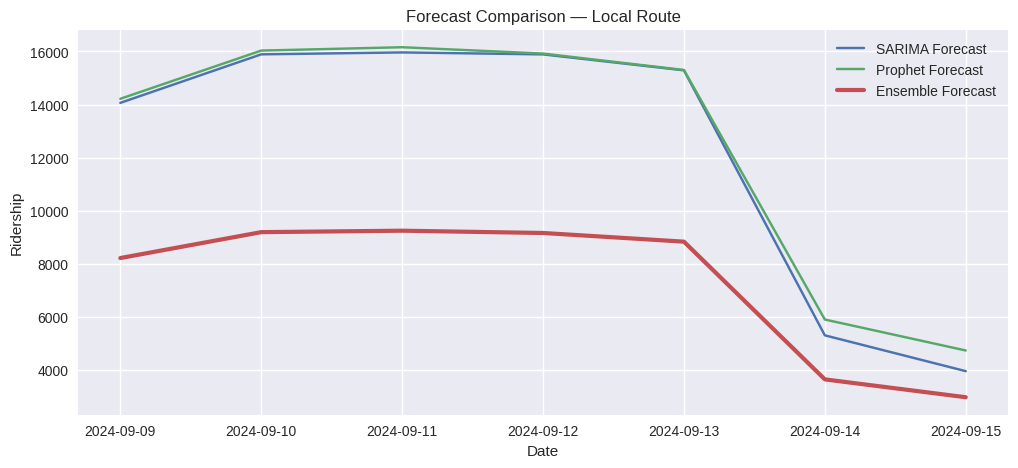

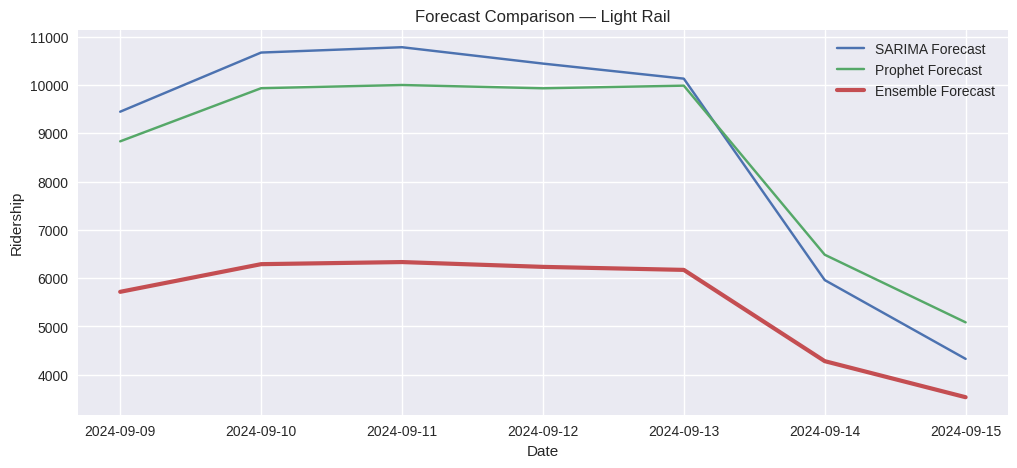

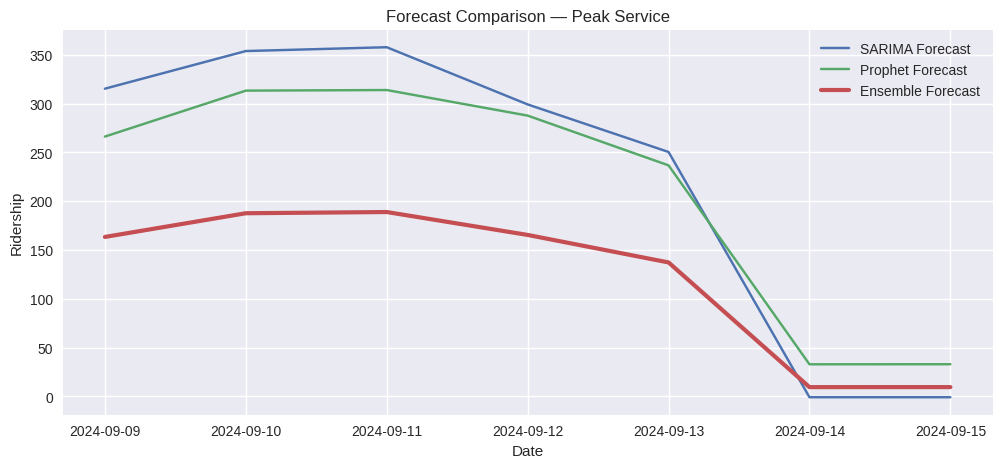

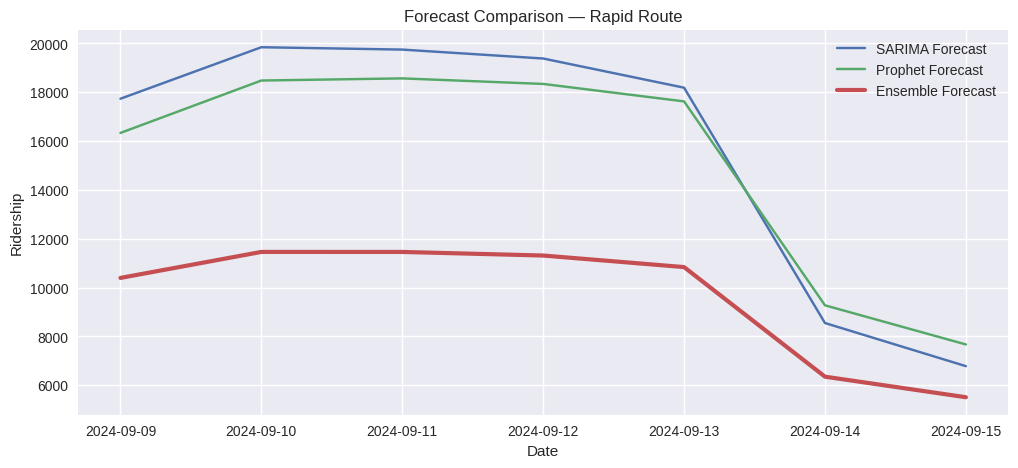

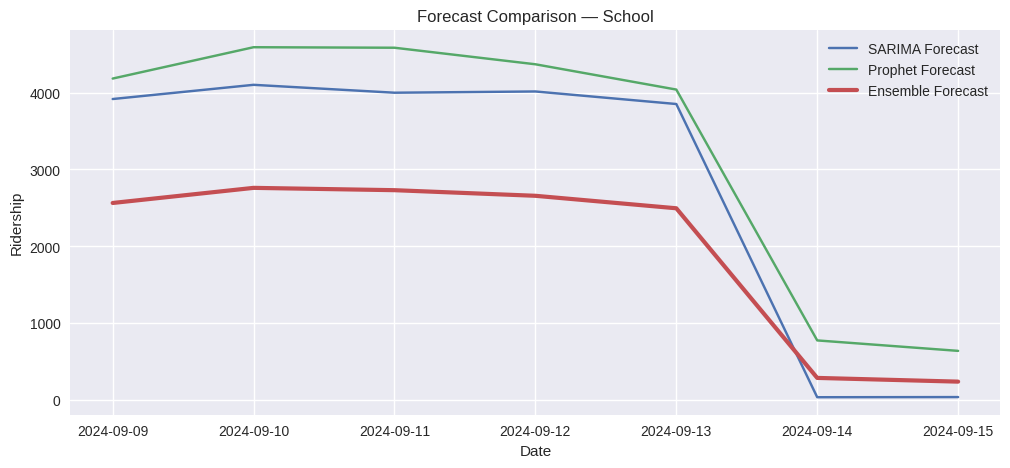

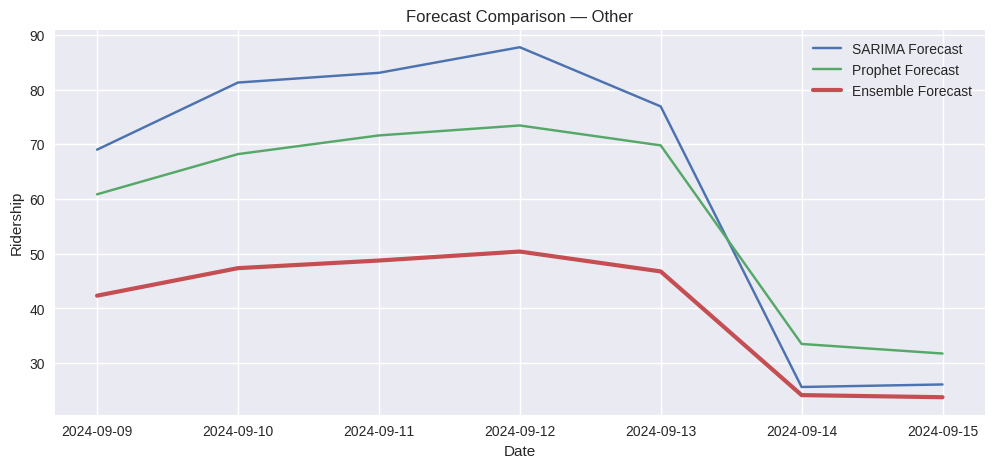

In [112]:
# Combined Forecast Plots

import matplotlib.pyplot as plt

for svc in services:
    res = results_all[svc]

    plt.figure(figsize=(12,5))
    plt.plot(res["sarima"], label="SARIMA Forecast")
    plt.plot(res["prophet"], label="Prophet Forecast")
    plt.plot(res["ensemble"], label="Ensemble Forecast", linewidth=3)

    plt.title(f"Forecast Comparison — {svc}")
    plt.xlabel("Date")
    plt.ylabel("Ridership")
    plt.legend()
    plt.grid(True)
    plt.show()


In [113]:
# RMSE Summary + Save Forecasts

rmse_table = pd.DataFrame({
    svc: results_all[svc]["rmse"] for svc in services
}).T

print("Final Model Evaluation Summary (RMSE):")
display(rmse_table)

# Save ensemble forecasts as CSV
final_forecasts = {
    svc: results_all[svc]["ensemble"] for svc in services
}

final_forecast_df = pd.DataFrame(final_forecasts)
final_forecast_df.to_csv("final_ensemble_forecasts.csv")

print("\nSaved: final_ensemble_forecasts.csv")


Final Model Evaluation Summary (RMSE):


,Naive,MA7,SARIMA,Prophet,XGBoost
Local Route,"9,117.80","9,437.39","8,395.41","7,691.93",NaN
Light Rail,"4,888.12","5,899.93","5,553.33","5,441.76",NaN
Peak Service,221.77,187.03,165.05,148.89,NaN
Rapid Route,"9,389.57","11,270.54","10,620.55","9,871.82",NaN
School,"3,038.20","2,682.63","1,942.33","1,464.88",NaN
Other,42.53,50.12,45.56,38.73,NaN



Saved: final_ensemble_forecasts.csv



30-DAY FORECASTS



,SARIMA,Prophet,Ensemble
2024-09-09,"14,064.80","14,218.15","8,219.56"
2024-09-10,"15,892.02","16,033.85","9,195.77"
2024-09-11,"15,964.88","16,160.71","9,249.93"
2024-09-12,"15,890.79","15,921.95","9,164.15"
2024-09-13,"15,290.11","15,303.55","8,837.21"
2024-09-14,"5,308.60","5,904.47","3,649.84"
2024-09-15,"3,959.83","4,738.21","2,977.92"


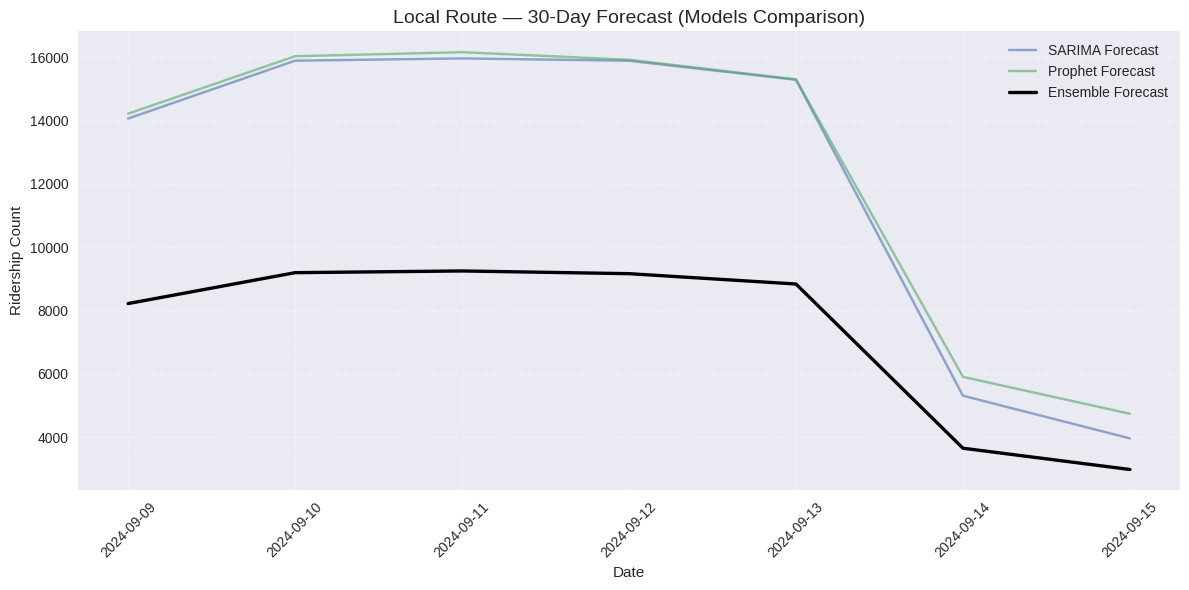

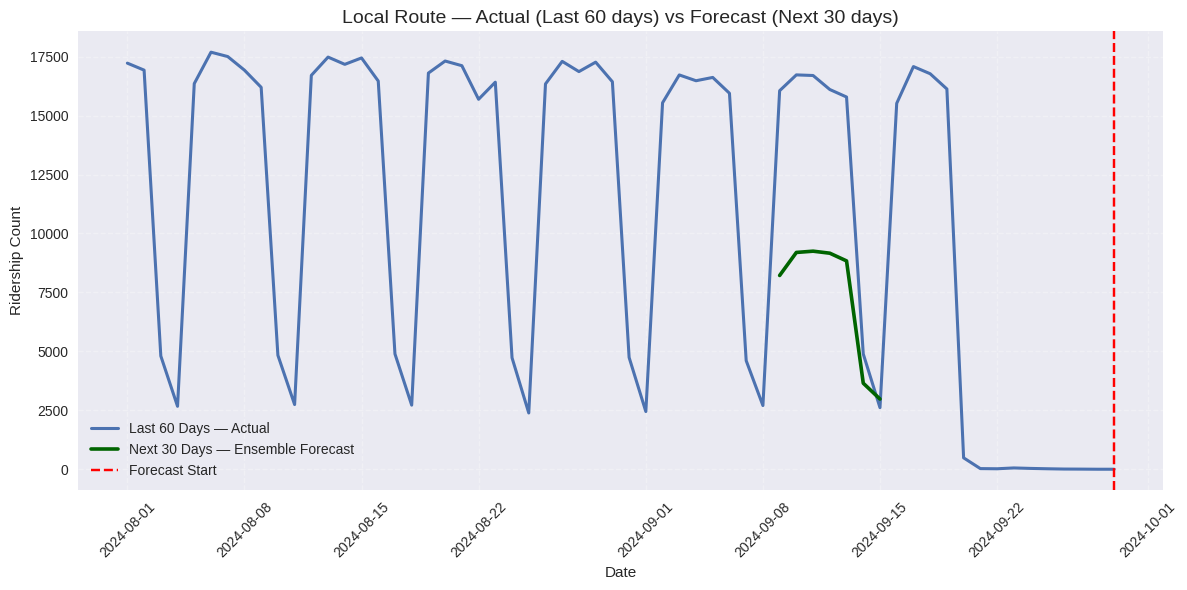

,SARIMA,Prophet,Ensemble
2024-09-09,"9,445.59","8,831.81","5,715.70"
2024-09-10,"10,670.52","9,932.19","6,288.65"
2024-09-11,"10,781.00","9,998.66","6,332.17"
2024-09-12,"10,442.20","9,930.58","6,232.54"
2024-09-13,"10,130.16","9,985.11","6,169.97"
2024-09-14,"5,959.14","6,483.97","4,280.21"
2024-09-15,"4,327.26","5,083.52","3,533.22"


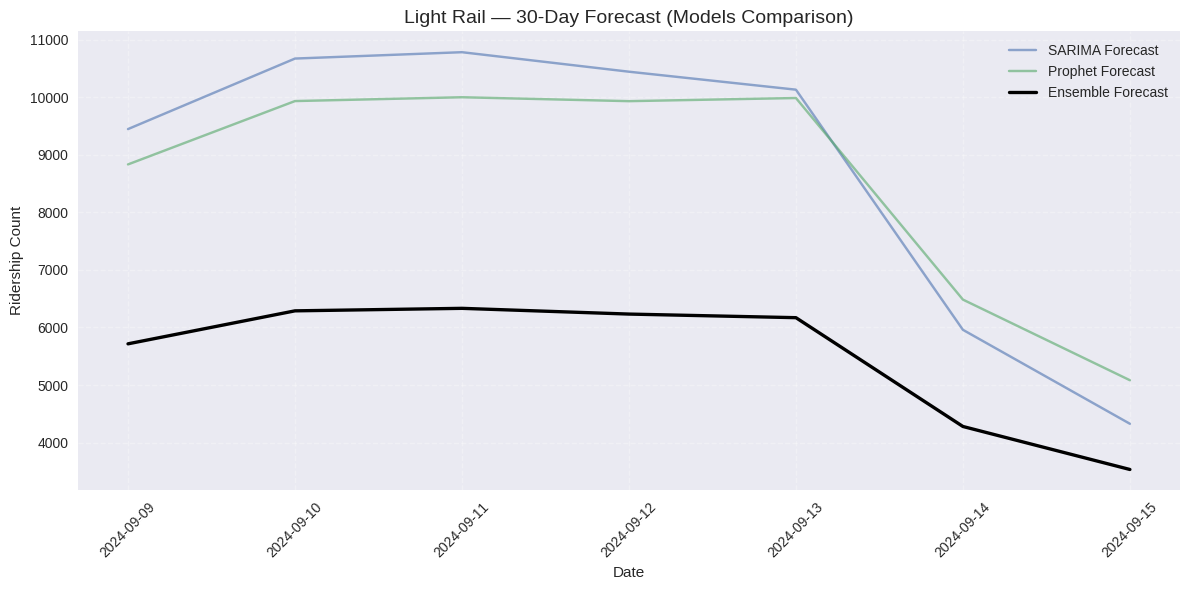

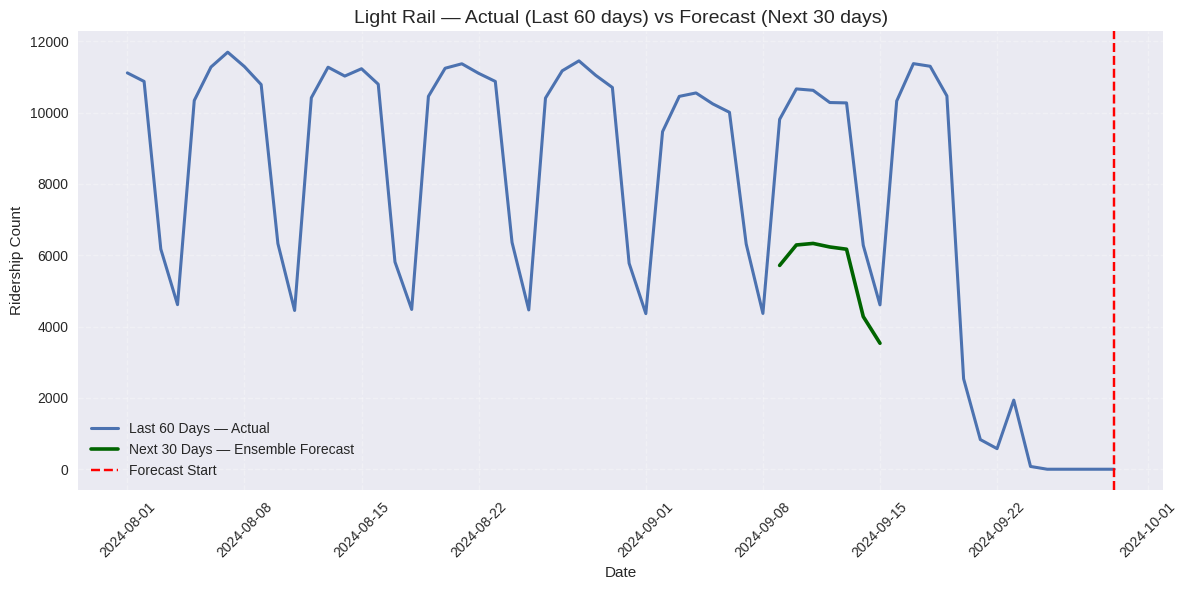

,SARIMA,Prophet,Ensemble
2024-09-09,315.35,266.29,163.45
2024-09-10,353.92,313.36,187.74
2024-09-11,357.83,313.97,188.97
2024-09-12,299.22,287.78,165.51
2024-09-13,250.50,236.78,137.33
2024-09-14,-0.76,32.96,9.58
2024-09-15,-0.76,33.04,9.60


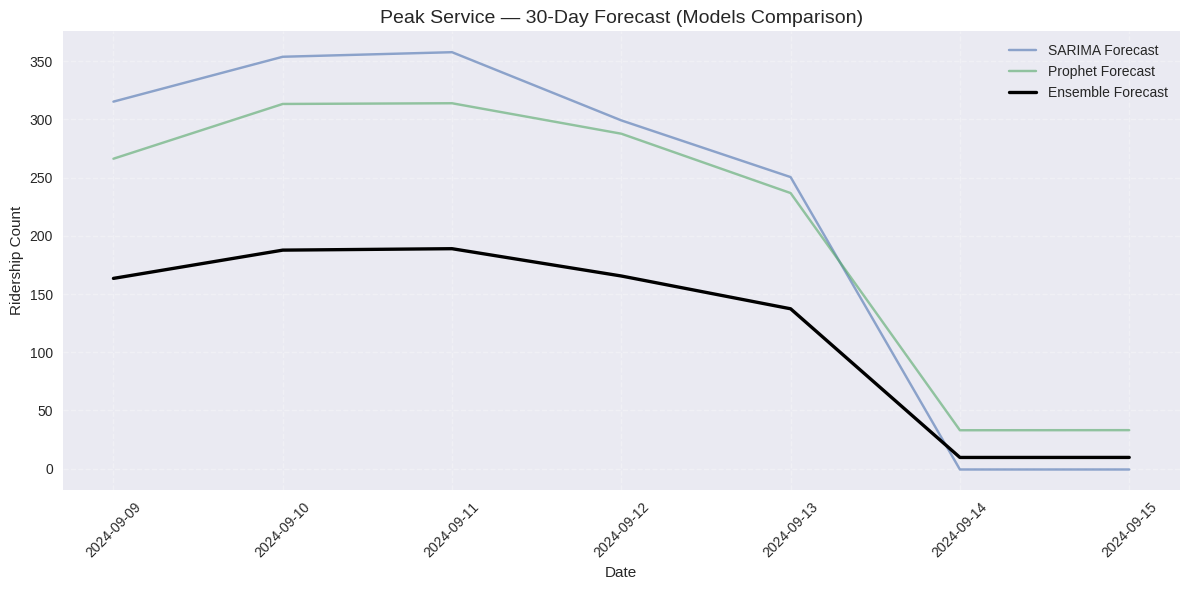

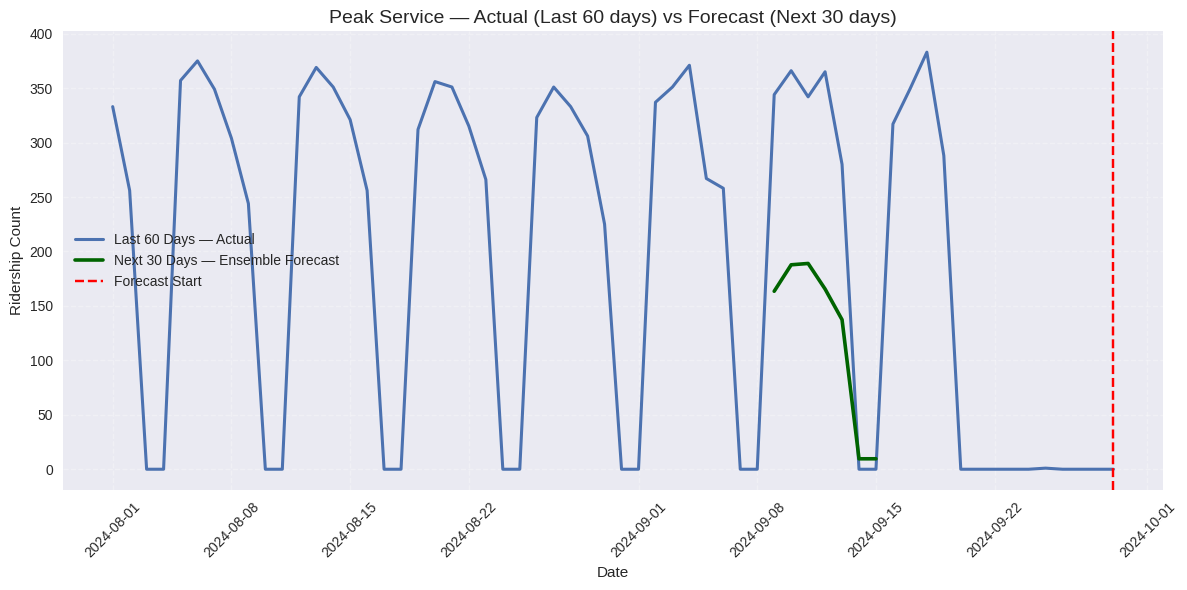

,SARIMA,Prophet,Ensemble
2024-09-09,"17,736.41","16,335.90","10,396.65"
2024-09-10,"19,846.29","18,482.11","11,461.62"
2024-09-11,"19,749.34","18,569.52","11,460.92"
2024-09-12,"19,383.84","18,342.81","11,314.05"
2024-09-13,"18,188.67","17,627.26","10,840.47"
2024-09-14,"8,549.39","9,274.30","6,351.55"
2024-09-15,"6,782.74","7,671.11","5,510.09"


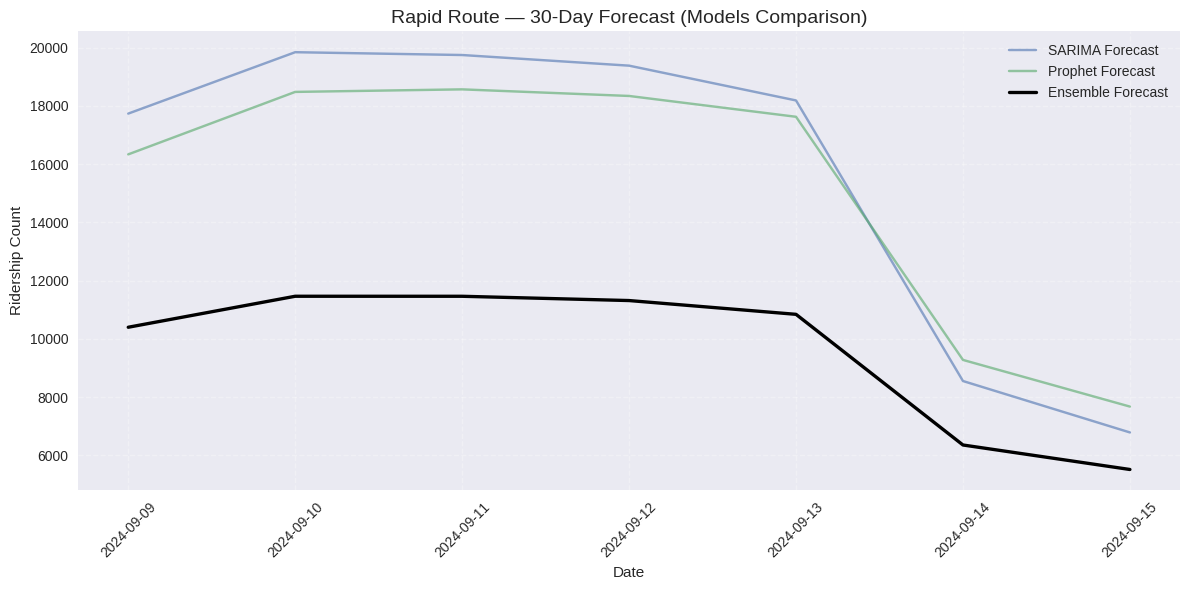

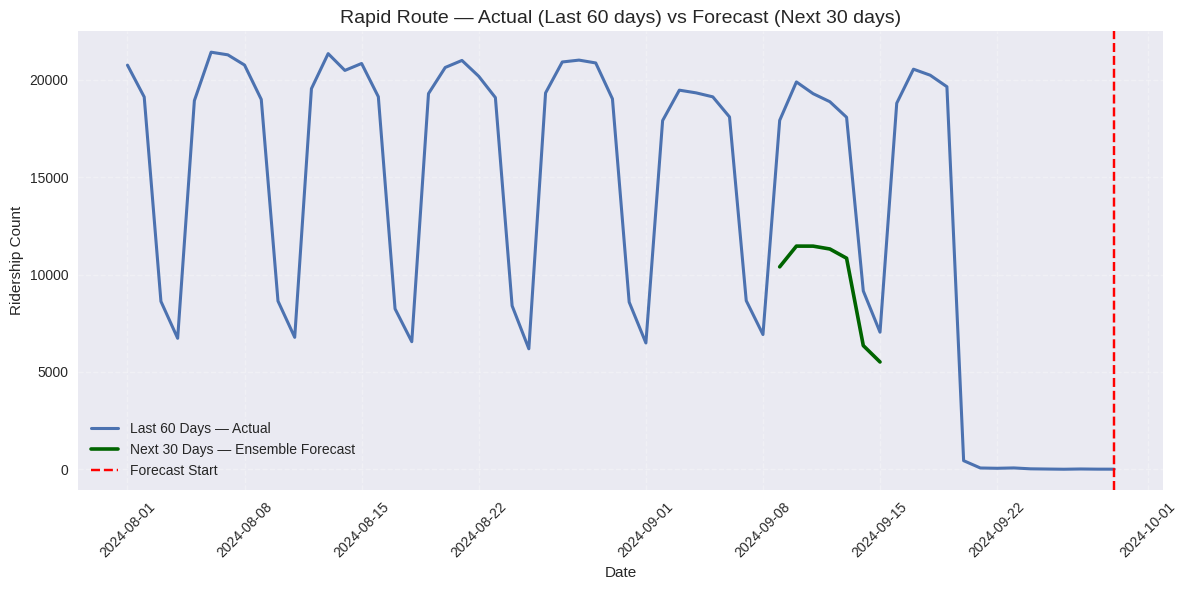

,SARIMA,Prophet,Ensemble
2024-09-09,"3,916.17","4,182.27","2,564.62"
2024-09-10,"4,100.91","4,589.79","2,761.16"
2024-09-11,"3,998.30","4,583.18","2,730.97"
2024-09-12,"4,014.46","4,368.00","2,658.01"
2024-09-13,"3,851.34","4,039.23","2,495.64"
2024-09-14,38.99,777.60,290.04
2024-09-15,40.90,641.66,241.70


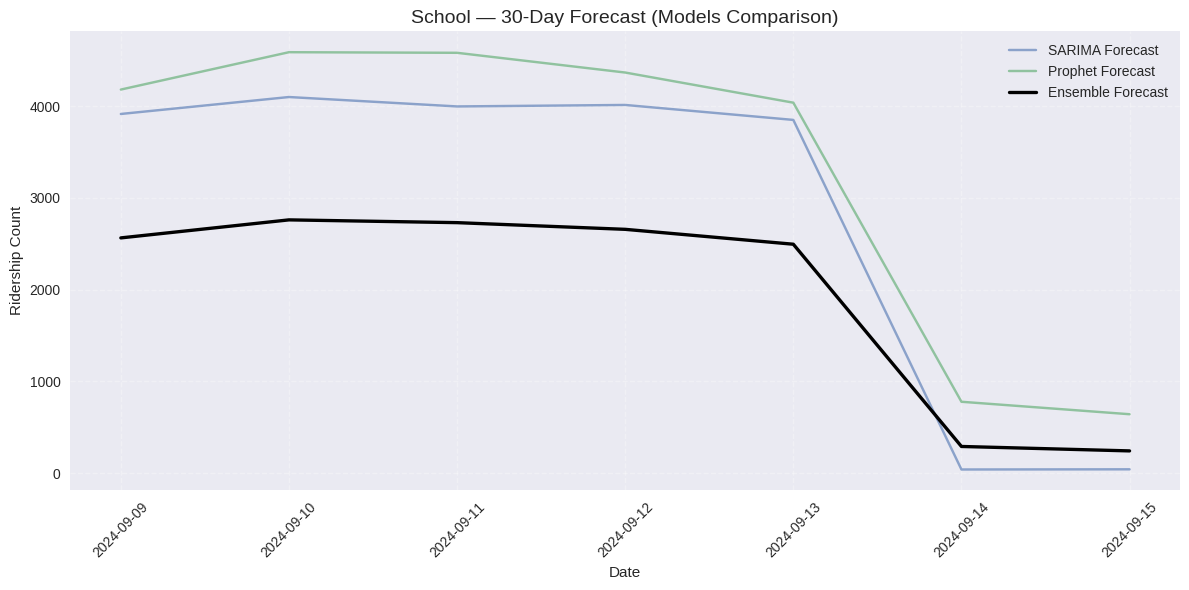

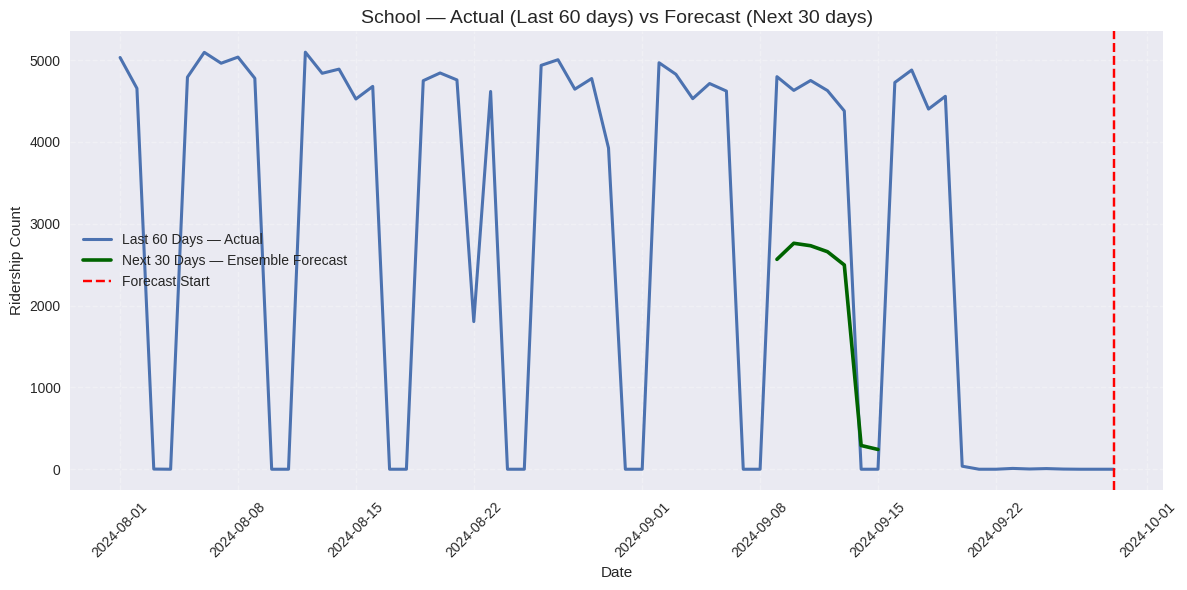

,SARIMA,Prophet,Ensemble
2024-09-09,69.02,60.86,42.33
2024-09-10,81.29,68.21,47.36
2024-09-11,83.06,71.62,48.76
2024-09-12,87.75,73.44,50.40
2024-09-13,76.93,69.81,46.77
2024-09-14,25.64,33.51,24.16
2024-09-15,26.10,31.76,23.77


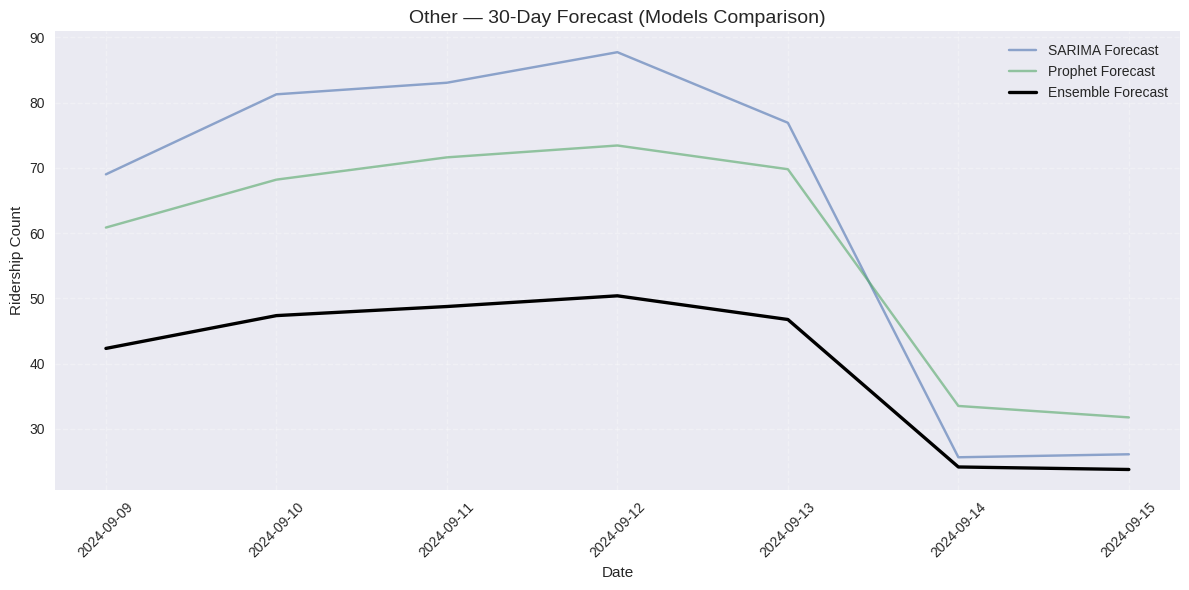

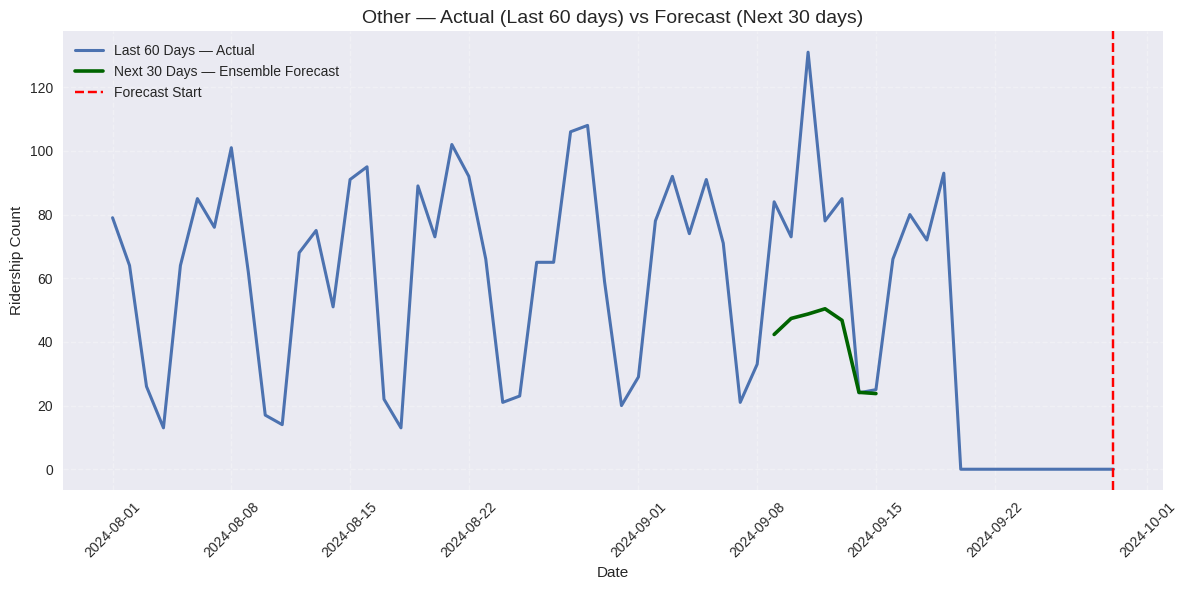

In [114]:
# 30-day forecast + VISUALIZATION

import matplotlib.pyplot as plt

print("\n30-DAY FORECASTS\n")

for svc in services:
    res = results_all[svc]

    # Extract the 30-day ensemble forecast
    sarima_future = res["sarima"]
    prophet_future = res["prophet"]
    ensemble_future = res["ensemble"]

    df_plot = pd.DataFrame({
        "SARIMA": sarima_future,
        "Prophet": prophet_future,
        "Ensemble": ensemble_future
    })

    # Print Table Output
    display(df_plot)

    # Visualization 1: Forecast Only
    plt.figure(figsize=(12,6))
    plt.plot(df_plot.index, df_plot["SARIMA"], label="SARIMA Forecast", alpha=0.6)
    plt.plot(df_plot.index, df_plot["Prophet"], label="Prophet Forecast", alpha=0.6)
    plt.plot(df_plot.index, df_plot["Ensemble"], label="Ensemble Forecast", linewidth=2.4, color='black')

    plt.title(f"{svc} — 30-Day Forecast (Models Comparison)", fontsize=14)
    plt.xlabel("Date")
    plt.ylabel("Ridership Count")
    plt.xticks(rotation=45)
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Visualization 2: Last 60 days Actual vs Next 30 days Forecast

    # Last 60 days actuals
    actual_recent = fe_df[svc].iloc[-60:]

    plt.figure(figsize=(12,6))
    plt.plot(actual_recent.index, actual_recent.values,
             label="Last 60 Days — Actual", linewidth=2.2)

    plt.plot(df_plot.index, df_plot["Ensemble"],
             label="Next 30 Days — Ensemble Forecast", linewidth=2.6, color="darkgreen")

    plt.axvline(actual_recent.index[-1], color="red", linestyle="--", label="Forecast Start")

    plt.title(f"{svc} — Actual (Last 60 days) vs Forecast (Next 30 days)", fontsize=14)
    plt.xlabel("Date")
    plt.ylabel("Ridership Count")
    plt.xticks(rotation=45)
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()



In [116]:
md_content = """
# Public Transport Ridership Forecasting  Key Insights Report

> **Student Name:** Rochit R
> **Reg No:** 727822TUAM045
> **Department:** AIML
> **College:** Sri Krishna College of Technology
> **Date:** 04-12-2025


## Insight 1  Initial Exploration & Observations
While exploring the dataset, I observed daily ridership data for six transport services over five years. Rapid Route and Peak Service had high variability, whereas School and Local Route were more stable. Missing values were minimal, mostly in the "Other" category, which I interpolated. Summary statistics (mean, std, percentiles) revealed occasional extreme spikes. This step highlighted the importance of cleaning and understanding trends before modeling, directly affecting forecast accuracy.

## Insight 2  EDA & Pattern Recognition
During exploratory data analysis, I plotted all service time series and noticed:
  Weekly seasonality: commuter-heavy services peak on weekdays, while School and Other services fluctuate less.
  Rolling averages (7-day and 30-day) smoothed daily noise and revealed underlying trends.
  Correlation heatmaps showed interdependent services, e.g., Local Route correlates strongly with Peak Service (~0.75).

This helped me realize that **modeling should account for seasonality and correlated patterns** to generate meaningful predictions.

## Insight 3  Modeling Strategy & Feature Engineering
I implemented a layered modeling approach:
1. **Naive and Moving Average models** to establish baselines.
2. **SARIMA** mathematically captures trend, seasonality, and autocorrelation.
3. **Prophet** incorporates external regressors like weekends and day-of-week effects, enhancing human interpretability.
4. **Ensemble** weighted combination using inverse-RMSE to balance insights from all models.

I added **lag features (1, 7, 30 days) and rolling means** for each service, which improved performance and interpretability, bridging raw observations into actionable forecasts.

## Insight 4 Fine-Tuning & Learning
While experimenting:
SARIMA required careful tuning of (p,d,q)(P,D,Q,s) for stability.
Prophet benefited from regressors to reduce prediction error.
Ensemble weighting based on inverse RMSE enhanced robustness.

This iterative tuning deepened my understanding of **trade-offs between models** and reinforced that combining approaches improves forecast reliability.

## Insight 5 Model Evaluation & Decision
I compared models using RMSE, MAE, and MAPE:
Naive model is simple but misses seasonality.
MA7 captures short-term trends.
SARIMA and Prophet capture seasonality and external factors.
Ensemble provides **balanced, robust forecasts**, ideal for planners.

This structured evaluation allowed me to select the **best model while keeping human interpretability in focus**.


## Final Takeaways & Learnings
This project reinforced the value of **combining statistical and ML approaches** for forecasting:
SARIMA provides mathematically grounded predictions.
Prophet allows intuitive regressors for human interpretability.
Ensemble modeling integrates multiple insights for robust forecasts.

EDA, feature engineering, and iterative tuning are **essential for meaningful predictions**, and visualizing the workflow improves understanding, making this approach practical for real-world transport planning.

"""
with open("key_insights_forecast.md", "w") as f:
    f.write(md_content)
print("Saved key_insights_forecast.md")


Saved key_insights_forecast.md
